# PROJECT 3

### TASK 1

In [ ]:
# Importing modules to manage file paths, system settings, and run terminal commands
import os
import sys
import subprocess

# Defining the folder name where the virtual environment will be created
VENV_PATH = "venv"

def setup_virtual_environment():
    # Checking if the virtual environment folder already exists
    if not os.path.exists(VENV_PATH):
        print("Creating virtual environment...")
        # If not, creating the virtual environment using the Python venv module
        subprocess.run([sys.executable, "-m", "venv", VENV_PATH])

    # Choosing the correct activation script based on the user's operating system
    if sys.platform == "win32":
        activate_script = os.path.join(VENV_PATH, "Scripts", "activate")  # For Windows
    else:
        activate_script = os.path.join(VENV_PATH, "bin", "activate")      # For macOS/Linux

    # Listing the packages required for this project (image classification and adversarial attacks)
    required_packages = [
        "torch",
        "torchvision",
        "numpy",
        "matplotlib",
        "tqdm",
        "Pillow"
    ]

    # Installing any package that is not already available
    for package in required_packages:
        try:
            __import__(package)  # Trying to import the package
        except ImportError:
            print(f"Installing package : {package}")
            # If not installed, installing it using pip
            subprocess.run([sys.executable, "-m", "pip", "install", package])

    print("Virtual environment and all required packages are ready!")

# Running the setup function to prepare the environment
setup_virtual_environment()

Installing package : Pillow
Virtual environment and all required packages are ready!



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Importing libraries for model loading, image handling, and progress tracking
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


# Selecting GPU(MPS) or CPU device for computation
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device : {device}")

# Setting random seeds to make results reproducible
torch.manual_seed(42)
np.random.seed(42)

Using device : mps


In [ ]:
# Defining ImageNet normalization values
# These values are used to bring image pixel values to a standard range
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Creating a transform that converts images to tensors and normalizes them using ImageNet statistics
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean_norms, std = std_norms)
])

# Loading dataset from folder
dataset_path = Path("./TestDataSet")
original_dataset = datasets.ImageFolder(root = dataset_path, transform = plain_transforms)

# Loading label mappings from JSON and extracting true ImageNet indices
# Each entry is like "407 : ambulance", where 407 is the actual ImageNet class index
with open(dataset_path / "labels_list.json", "r") as f:
    raw_labels = json.load(f)

# Extracting just the numerical ImageNet class index from each label string
imagenet_indices = [int(entry.split(":")[0]) for entry in raw_labels]

# Creating a mapping from internal dataset class index (0 - 99) to ImageNet class index (401 - 500)
# This is necessary because ImageFolder assigns class 0 to the first alphabetically sorted folder
class_index_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

# Creating a custom dataset that replaces ImageFolder labels with the correct ImageNet labels
class CorrectedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, class_idx_map):
        self.base = base_dataset
        self.class_map = class_idx_map

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        image, label = self.base[idx]
        return image, self.class_map[label]

# Wrapping the dataset so that it returns correct labels during training and evaluation
dataset = CorrectedLabelDataset(original_dataset, class_index_map)
print(f"Loaded {len(dataset)} images with corrected ImageNet labels.")

Loaded 500 images with corrected ImageNet labels.


In [ ]:
# Printing key dataset configuration for transparency
print("Dataset Configuration :")
print(f"Total images loaded                     : {len(dataset)}")
print(f"Total class folders                     : {len(original_dataset.classes)}")
print(f"Class label range (ImageNet indices)    : {min(imagenet_indices)} to {max(imagenet_indices)}")
print(f"Sample class folders                    : {original_dataset.classes[ : 5]}")

Dataset Configuration :
Total images loaded                     : 500
Total class folders                     : 100
Class label range (ImageNet indices)    : 401 to 500
Sample class folders                    : ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']


In [ ]:
# Loading the ResNet-34 model pre-trained on ImageNet-1K
resnet34 = torchvision.models.resnet34(weights = 'IMAGENET1K_V1').to(device)
resnet34.eval()

# Creating a DataLoader for batch evaluation
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = False)

# Tracking accuracy
top1_correct = 0
top5_correct = 0
total_images = 0

with torch.no_grad():
    for images, labels in tqdm(dataloader, desc = "Evaluating Original Set"):
        images = images.to(device)
        labels = labels.to(device)

        # Getting predictions from the model
        outputs = resnet34(images)

        # Getting the top 5 predicted classes for each image
        _, top5_preds = outputs.topk(5, dim = 1)

        # Top-1 : comparing the most confident prediction to the true label
        top1_correct += (top5_preds[:, 0] == labels).sum().item()
        # Top-5 : checking if the correct label appears in any of the top 5 guesses
        top5_correct += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        total_images += labels.size(0)

# Printing the baseline accuracy
print(f"\nTop-1 Accuracy : {100 * top1_correct / total_images:.2f}%")
print(f"Top-5 Accuracy : {100 * top5_correct / total_images:.2f}%")

Evaluating Original Set: 100%|██████████| 32/32 [00:02<00:00, 13.64it/s]


Top-1 Accuracy : 76.00%
Top-5 Accuracy : 94.20%


### TASK 2

In [ ]:
# Defining the Fast Gradient Sign Method (FGSM) for generating adversarial examples
# This function perturbs the image in the direction that increases the model's error
def fgsm_attack(image, label, model, loss_fn, epsilon):
    image.requires_grad = True

    # Running a forward pass through the model
    output = model(image)

    # Calculating the cross-entropy loss between output and true label
    loss = loss_fn(output, label)

    # Backward pass to compute gradients with respect to the input image
    model.zero_grad()
    loss.backward()

    # Creating perturbation by taking the sign of the gradient
    perturbation = epsilon * image.grad.sign()

    # Adding perturbation to the original image
    adv_image = image + perturbation

    # Clamping to maintain valid range after normalization
    min_vals = torch.tensor(((0.0 - mean_norms) / std_norms), dtype = torch.float32, device = image.device).view(-1, 1, 1)
    max_vals = torch.tensor(((1.0 - mean_norms) / std_norms), dtype = torch.float32, device = image.device).view(-1, 1, 1)
    adv_image = torch.max(torch.min(adv_image, max_vals), min_vals)

    # Detaching from computation graph and returning
    return adv_image.detach()

In [ ]:
# Setting the FGSM perturbation limit (ε), which defines how much each pixel can change
# 0.02 is a small value chosen to keep images visually similar but still fool the model
epsilon = 0.02

# Cross-entropy is used because it measures how wrong the model is
loss_fn = torch.nn.CrossEntropyLoss()

# Generating adversarial images
adversarial_images = []
adversarial_labels = []

# Creating a DataLoader to go through the original dataset one image at a time
adv_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
print("Generating Adversarial Test Set 1 :")

resnet34.eval()
for image, label in tqdm(adv_loader, desc = "Attacking"):
    image = image.to(device)
    label = label.to(device)

    # Applying the FGSM attack to create a perturbed (adversarial) version of the image
    adv_image = fgsm_attack(image, label, resnet34, loss_fn, epsilon)

    # Storing the generated adversarial image and its label (still the original label)
    adversarial_images.append(adv_image.cpu().squeeze())
    adversarial_labels.append(label.cpu().item())

# Creating final adversarial dataset
adversarial_dataset_1 = torch.utils.data.TensorDataset(
    torch.stack(adversarial_images),                    # Stacking all images into a single tensor
    torch.tensor(adversarial_labels)                    # Converting list of labels to tensor
)

print(f"Created Adversarial Test Set 1 with {len(adversarial_dataset_1)} images.")

Generating Adversarial Test Set 1 :


Attacking: 100%|██████████| 500/500 [00:15<00:00, 31.78it/s]

Created Adversarial Test Set 1 with 500 images.


In [ ]:
# Evaluating model on adversarial test set
adv_loader = torch.utils.data.DataLoader(adversarial_dataset_1, batch_size = 16, shuffle = False)

top1_adv = 0
top5_adv = 0
total_adv = 0

with torch.no_grad():
    for images, labels in tqdm(adv_loader, desc = "Evaluating Adversarial Set 1"):
        images = images.to(device)
        labels = labels.to(device)

        # Getting model predictions for each adversarial image
        outputs = resnet34(images)

        # Selecting the top 5 predicted class indices for each image
        _, top5_preds = outputs.topk(5, dim = 1)

        # Top-1 : comparing the most confident prediction to the true label
        top1_adv += (top5_preds[:, 0] == labels).sum().item()

        # Top-5 : checking if the correct label appears in any of the top 5 guesses
        for i in range(labels.size(0)):
            if labels[i] in top5_preds[i]:
                top5_adv += 1

        # Updating the total number of evaluated images
        total_adv += labels.size(0)

print(f"\nTop-1 Accuracy on Adversarial Set : {100 * top1_adv / total_adv:.2f}%")
print(f"Top-5 Accuracy on Adversarial Set : {100 * top5_adv / total_adv:.2f}%")

Evaluating Adversarial Set 1: 100%|██████████| 32/32 [00:01<00:00, 16.34it/s]


Top-1 Accuracy on Adversarial Set : 6.20%
Top-5 Accuracy on Adversarial Set : 35.40%


In [ ]:
# Calculating number of images where the adversarial attack succeeded
# i.e. model's top-1 prediction was incorrect
misclassified = total_adv - top1_adv
success_rate = 100 * misclassified / total_adv

# Displaying the number of successful adversarial attacks
print(f"Adversarial Attack Success Count : {misclassified}/{total_adv}")
print(f"Attack Success Rate (misclassified) : {success_rate:.2f}%")

Adversarial Attack Success Count : 469/500
Attack Success Rate (misclassified) : 93.80%


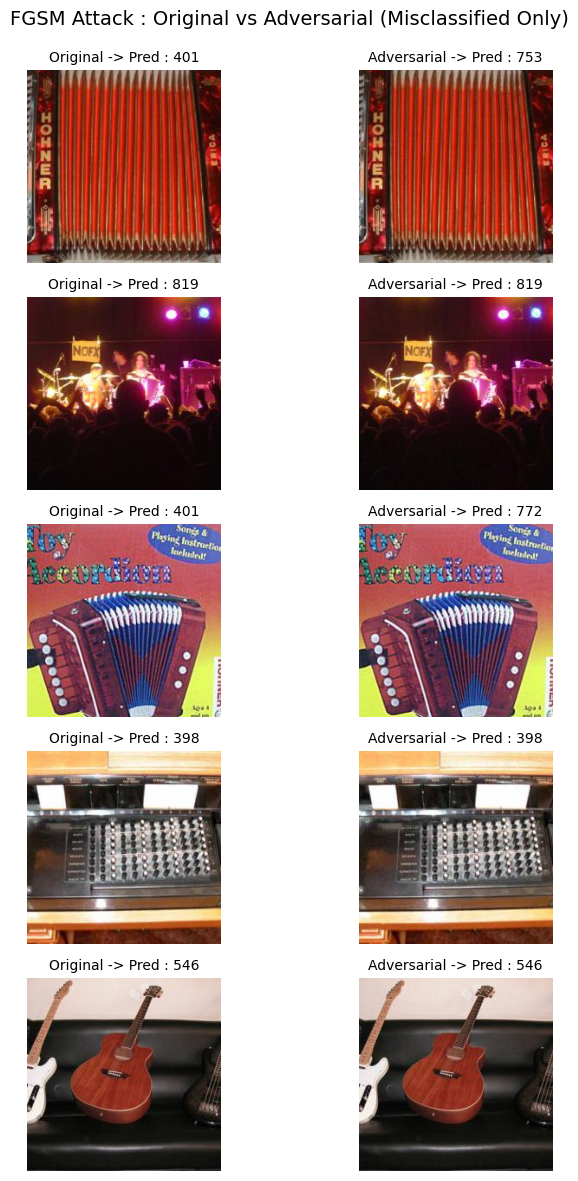

In [ ]:
# Creating a new DataLoader to loop through adversarial + original images together
adv_loader = torch.utils.data.DataLoader(adversarial_dataset_1, batch_size = 1, shuffle = False)
orig_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)

# Putting the model in eval mode again to be safe
resnet34.eval()

# Defining a helper function to unnormalize and convert image tensor to NumPy array
def denormalize_and_convert(tensor):
    # Converting normalized image tensor back to [0, 1] range for display
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

# Setting up plot
fig, axes = plt.subplots(5, 2, figsize = (8, 12))
fig.suptitle("FGSM Attack : Original vs Adversarial (Misclassified Only)", fontsize = 14)

shown = 0       # Counter for how many examples we’ve displayed

# Looping through original and adversarial images together
for (orig_img, label), (adv_img, _) in zip(orig_loader, adv_loader):
    if shown >= 5:
        break

    orig_img = orig_img.to(device)
    adv_img = adv_img.to(device)
    label = label.to(device)

    # Get predictions for original and adversarial
    with torch.no_grad():
        pred_orig = resnet34(orig_img).argmax(dim = 1).item()
        pred_adv = resnet34(adv_img).argmax(dim = 1).item()

    # Show only if the adversarial image is misclassified
    if pred_adv != label.item():
        # Plotting original image
        axes[shown, 0].imshow(denormalize_and_convert(orig_img.squeeze()))
        axes[shown, 0].set_title(f"Original -> Pred : {pred_orig}", fontsize = 10)
        axes[shown, 0].axis('off')

        # Plotting adversarial image
        axes[shown, 1].imshow(denormalize_and_convert(adv_img.squeeze()))
        axes[shown, 1].set_title(f"Adversarial -> Pred : {pred_adv}", fontsize = 10)
        axes[shown, 1].axis('off')

        shown += 1

plt.tight_layout()
plt.subplots_adjust(top = 0.93)
plt.show()

In [ ]:
save_path = "./adversarial_test_set_1.pt"

# Saving the adversarial dataset as a PyTorch .pt file
torch.save(adversarial_dataset_1, save_path)

print(f"Saved Adversarial Test Set 1 to : {save_path}")

Saved Adversarial Test Set 1 to : ./adversarial_test_set_1.pt


### TASK 3

In [ ]:
# Defining the PGD (Projected Gradient Descent) attack function
# This function generates an adversarial image by applying small perturbations in multiple steps

def pgd_attack(image, label, model, loss_fn, epsilon, alpha, num_iters):
    # Creating a copy of the input image to start the attack
    adv_image = image.clone().detach().to(image.device)
    adv_image.requires_grad = True

    # Starting the attack loop
    for i in range(num_iters):
        # Making sure gradients from previous iterations are cleared
        model.zero_grad()

        # Forward pass to get the model's predictions
        output = model(adv_image)

        # Calculating the loss with respect to the correct label
        loss = loss_fn(output, label)

        # Backpropagating the loss to compute gradient w.r.t. input image
        loss.backward()

        # Applying perturbation: taking a small step in the direction of gradient sign
        with torch.no_grad():
            adv_image = adv_image + alpha * adv_image.grad.sign()

            # Clipping to ensure total perturbation stays within the allowed epsilon-ball
            perturbation = torch.clamp(adv_image - image, min = -epsilon, max = epsilon)
            adv_image = image + perturbation

            # Clipping again to ensure pixel values stay in valid normalized range
            min_vals = torch.tensor(((0.0 - mean_norms) / std_norms), dtype = torch.float32, device = image.device).view(-1, 1, 1)
            max_vals = torch.tensor(((1.0 - mean_norms) / std_norms), dtype = torch.float32, device = image.device).view(-1, 1, 1)
            adv_image = torch.max(torch.min(adv_image, max_vals), min_vals)

        # Resetting the image to require gradients again for the next iteration
        adv_image.requires_grad = True

    # Detaching from the computation graph before returning
    return adv_image.detach()

In [ ]:
# Defining PGD attack configuration
epsilon = 0.02          # Total allowable perturbation (same as FGSM)
alpha = 0.005           # Step size per iteration
num_iters = 10          # Number of PGD iterations

# Cross-entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Initializing lists to store PGD adversarial images and their labels
pgd_images = []
pgd_labels = []

# Creating a DataLoader to go through the original dataset one image at a time
pgd_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
print("Generating Adversarial Test Set 2 using PGD Attack :")

# Making sure the model is in evaluation mode
resnet34.eval()

# Looping through each image in the dataset
for image, label in tqdm(pgd_loader, desc = "Attacking with PGD"):
    image = image.to(device)
    label = label.to(device)

    # Applying PGD to generate the adversarial image
    adv_image = pgd_attack(image, label, resnet34, loss_fn, epsilon, alpha, num_iters)

    # Storing the adversarial image and its corresponding label
    pgd_images.append(adv_image.cpu().squeeze())
    pgd_labels.append(label.cpu().item())

# Stacking all generated PGD adversarial images into a dataset
adversarial_dataset_2 = torch.utils.data.TensorDataset(
    torch.stack(pgd_images),        # Tensor of shape [500, 3, H, W]
    torch.tensor(pgd_labels)        # Corresponding labels
)

print(f"Created Adversarial Test Set 2 with {len(adversarial_dataset_2)} images.")

Generating Adversarial Test Set 2 using PGD Attack :


Attacking with PGD: 100%|██████████| 500/500 [02:18<00:00,  3.60it/s]

Created Adversarial Test Set 2 with 500 images.


In [ ]:
# Creating a DataLoader for evaluating PGD-based adversarial images
pgd_eval_loader = torch.utils.data.DataLoader(adversarial_dataset_2, batch_size = 16, shuffle = False)

# Initializing counters to track accuracy and total image count
top1_pgd = 0
top5_pgd = 0
total_pgd = 0

# Ensuring model is in evaluation mode
resnet34.eval()

print("Evaluating Adversarial Test Set 2 (PGD) :")

# Disabling gradient computation for faster evaluation
with torch.no_grad():
    for images, labels in tqdm(pgd_eval_loader, desc = "Evaluating PGD Set"):
        images = images.to(device)
        labels = labels.to(device)

        # Getting predictions from the model
        outputs = resnet34(images)

        # Extracting top 5 predicted classes
        _, top5_preds = outputs.topk(5, dim = 1)

        # Counting top-1 and top-5 correct predictions
        top1_pgd += (top5_preds[:, 0] == labels).sum().item()
        top5_pgd += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])
        total_pgd += labels.size(0)

# Calculating final accuracy metrics
print(f"Top-1 Accuracy on Adversarial Set 2 (PGD) : {100 * top1_pgd / total_pgd:.2f}%")
print(f"Top-5 Accuracy on Adversarial Set 2 (PGD) : {100 * top5_pgd / total_pgd:.2f}%")

Evaluating Adversarial Test Set 2 (PGD) :


Evaluating PGD Set: 100%|██████████| 32/32 [00:01<00:00, 16.30it/s]

Top-1 Accuracy on Adversarial Set 2 (PGD) : 0.00%
Top-5 Accuracy on Adversarial Set 2 (PGD) : 9.80%


In [ ]:
# Calculating success of adversarial attack (misclassification rate)
misclassified_pgd = total_pgd - top1_pgd
success_rate_pgd = 100 * misclassified_pgd / total_pgd

# Printing adversarial success results
print(f"Adversarial Attack Success Count (PGD) : {misclassified_pgd}/{total_pgd}")
print(f"Attack Success Rate (misclassified) : {success_rate_pgd:.2f}%")

Adversarial Attack Success Count (PGD) : 500/500
Attack Success Rate (misclassified) : 100.00%


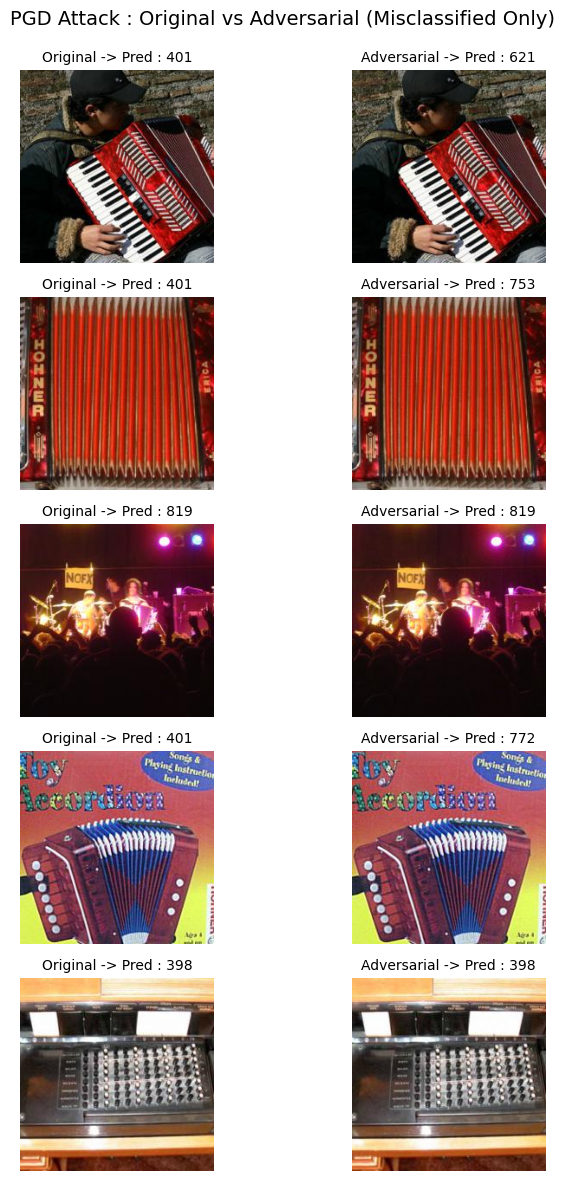

In [ ]:
# Creating loaders for original and PGD-based adversarial datasets
orig_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
pgd_loader = torch.utils.data.DataLoader(adversarial_dataset_2, batch_size = 1, shuffle = False)

# Putting model into evaluation mode again
resnet34.eval()

# Setting up the plot
fig, axes = plt.subplots(5, 2, figsize = (8, 12))
fig.suptitle("PGD Attack : Original vs Adversarial (Misclassified Only)", fontsize = 14)

shown = 0

# Defining helper to unnormalize image for visualization
def denormalize_and_convert(tensor):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

# Looping through original and adversarial image pairs
for (orig_img, label), (adv_img, _) in zip(orig_loader, pgd_loader):
    if shown >= 5:
        break

    orig_img = orig_img.to(device)
    adv_img = adv_img.to(device)
    label = label.to(device)

    # Getting model predictions
    with torch.no_grad():
        pred_orig = resnet34(orig_img).argmax(dim = 1).item()
        pred_adv = resnet34(adv_img).argmax(dim = 1).item()

    # Showing only if PGD adversarial prediction is wrong
    if pred_adv != label.item():
        # Plotting original image
        axes[shown, 0].imshow(denormalize_and_convert(orig_img.squeeze()))
        axes[shown, 0].set_title(f"Original -> Pred : {pred_orig}", fontsize = 10)
        axes[shown, 0].axis('off')

        # Plotting adversarial image
        axes[shown, 1].imshow(denormalize_and_convert(adv_img.squeeze()))
        axes[shown, 1].set_title(f"Adversarial -> Pred : {pred_adv}", fontsize = 10)
        axes[shown, 1].axis('off')

        shown += 1

# Adjusting layout and displaying plot
plt.tight_layout()
plt.subplots_adjust(top = 0.93)
plt.show()

In [ ]:
save_pgd_path = "./adversarial_test_set_2.pt"

# Saving the adversarial dataset 2 as a .pt file
torch.save(adversarial_dataset_2, save_pgd_path)

print(f"Saved Adversarial Test Set 2 (PGD) to : {save_pgd_path}")

Saved Adversarial Test Set 2 (PGD) to : ./adversarial_test_set_2.pt


### TASK 4

In [ ]:
# Defining PGD attack that perturbs only a small 32×32 patch in the image (Untargeted is giving better results than Targted attack)

def pgd_patch_attack(image, label, model, loss_fn, epsilon, alpha, num_iters, patch_size = 32):
    # Get spatial dimensions of the image
    _, C, H, W = image.shape

    # Randomly choosing the top-left corner of the 32×32 patch
    top = np.random.randint(0, H - patch_size)
    left = np.random.randint(0, W - patch_size)

    # Creating a binary mask (same size as the image) to restrict updates to the patch
    mask = torch.zeros_like(image).to(image.device)
    mask[:, :, top:top+patch_size, left:left+patch_size] = 1.0

    # Cloning the image and allowing gradients
    adv_image = image.clone().detach().to(image.device)
    adv_image.requires_grad = True

    for i in range(num_iters):
        # Zero out old gradients
        model.zero_grad()

        # Forward pass
        output = model(adv_image)
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        with torch.no_grad():
            # Getting sign of gradients and masking only patch region
            grad_sign = adv_image.grad.sign() * mask

            # Performing one PGD update step within the patch only
            adv_image = adv_image + alpha * grad_sign

            # Projecting updated image into epsilon-ball around the original (only in patch)
            perturbation = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
            adv_image = image + perturbation * mask + image * (1 - mask)

            # Clamping values to normalized image bounds
            min_vals = torch.tensor(((0.0 - mean_norms) / std_norms), dtype=torch.float32, device=image.device).view(-1, 1, 1)
            max_vals = torch.tensor(((1.0 - mean_norms) / std_norms), dtype=torch.float32, device=image.device).view(-1, 1, 1)
            adv_image = torch.max(torch.min(adv_image, max_vals), min_vals)

        # Enabling gradients for the next iteration
        adv_image.requires_grad = True

    return adv_image.detach()

In [ ]:
# Setting patch attack configuration
epsilon_patch = 0.3         # Increasing epsilon since patch is small
alpha_patch = 0.01          # Step size for each PGD iteration
num_iters_patch = 15        # Number of iterations for PGD

# Cross-entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Initializing empty lists to store patch adversarial images and labels
patch_images = []
patch_labels = []

# Creating a DataLoader to go through the original dataset one image at a time
patch_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
print("Generating Adversarial Test Set 3 using Patch-PGD Attack :")

# Making sure the model is in evaluation mode
resnet34.eval()

# Looping through the dataset and applying the patch-based PGD attack
for image, label in tqdm(patch_loader, desc = "Attacking with Patch-PGD"):
    image = image.to(device)
    label = label.to(device)

    # Creating an adversarial image by attacking only a 32×32 patch
    adv_image = pgd_patch_attack(image, label, resnet34, loss_fn, epsilon_patch, alpha_patch, num_iters_patch)

    # Storing the perturbed image and its true label
    patch_images.append(adv_image.cpu().squeeze())
    patch_labels.append(label.cpu().item())

# Creating a new dataset from all the adversarial patch images and labels
adversarial_dataset_3 = torch.utils.data.TensorDataset(
    torch.stack(patch_images),
    torch.tensor(patch_labels)
)

# Printing confirmation message
print(f"Created Adversarial Test Set 3 with {len(adversarial_dataset_3)} images.")

Generating Adversarial Test Set 3 using Patch-PGD Attack :


Attacking with Patch-PGD: 100%|██████████| 500/500 [03:45<00:00,  2.22it/s]

Created Adversarial Test Set 3 with 500 images.


In [ ]:
# Creating a DataLoader for evaluating the patch-based adversarial dataset
patch_eval_loader = torch.utils.data.DataLoader(adversarial_dataset_3, batch_size = 16, shuffle = False)

# Initializing counters
top1_patch = 0
top5_patch = 0
total_patch = 0

resnet34.eval()

print("Evaluating Adversarial Test Set 3 (Patch-PGD) :")

# Turning off gradient calculation to speed up evaluation
with torch.no_grad():
    for images, labels in tqdm(patch_eval_loader, desc = "Evaluating Patch-PGD Set"):
        images = images.to(device)
        labels = labels.to(device)

        # Getting predictions from the model
        outputs = resnet34(images)

        # Extracting top 5 predicted class indices
        _, top5_preds = outputs.topk(5, dim = 1)

        # Counting how many top-1 and top-5 predictions are correct
        top1_patch += (top5_preds[:, 0] == labels).sum().item()
        top5_patch += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])
        total_patch += labels.size(0)

# Calculating and printing final accuracy metrics
print(f"Top-1 Accuracy on Adversarial Set 3 (Patch-PGD) : {100 * top1_patch / total_patch:.2f}%")
print(f"Top-5 Accuracy on Adversarial Set 3 (Patch-PGD) : {100 * top5_patch / total_patch:.2f}%")

Evaluating Adversarial Test Set 3 (Patch-PGD) :


Evaluating Patch-PGD Set: 100%|██████████| 32/32 [00:01<00:00, 16.21it/s]

Top-1 Accuracy on Adversarial Set 3 (Patch-PGD) : 45.40%
Top-5 Accuracy on Adversarial Set 3 (Patch-PGD) : 77.20%


In [ ]:
# Calculating and printing attack success rate
misclassified_patch = total_patch - top1_patch
success_rate_patch = 100 * misclassified_patch / total_patch

print(f"Adversarial Attack Success Count (Patch-PGD) : {misclassified_patch}/{total_patch}")
print(f"Attack Success Rate (misclassified) : {success_rate_patch:.2f}%")

Adversarial Attack Success Count (Patch-PGD) : 273/500
Attack Success Rate (misclassified) : 54.60%


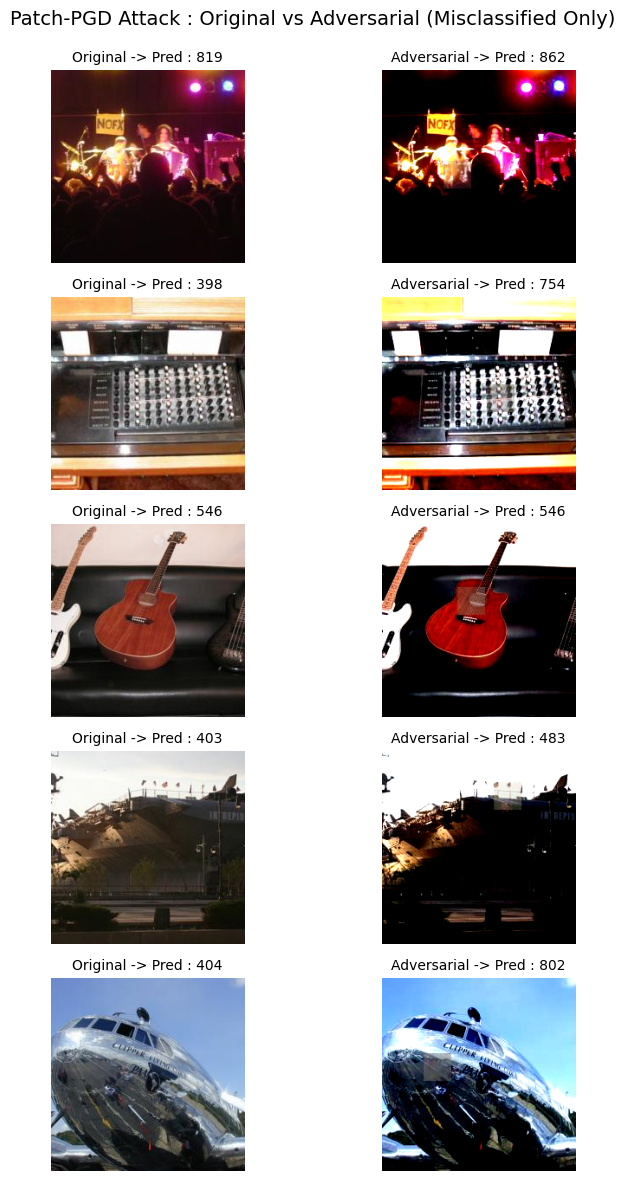

In [ ]:
# Creating DataLoaders for original and patch adversarial images
orig_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)
patch_loader = torch.utils.data.DataLoader(adversarial_dataset_3, batch_size = 1, shuffle = False)

# Making sure the model is in evaluation mode again
resnet34.eval()

# Setting up a 5-row, 2-column plot for side-by-side comparisons
fig, axes = plt.subplots(5, 2, figsize = (8, 12))
fig.suptitle("Patch-PGD Attack : Original vs Adversarial (Misclassified Only)", fontsize = 14)

shown = 0  # Counter to limit to 5 images

# Looping through original and patch-adversarial pairs together
for (orig_img, label), (adv_img, _) in zip(orig_loader, patch_loader):
    if shown >= 5:
        break

    # Moving data to the computation device
    orig_img = orig_img.to(device)
    adv_img = adv_img.to(device)
    label = label.to(device)

    # Getting predictions from the model
    with torch.no_grad():
        pred_orig = resnet34(orig_img).argmax(dim = 1).item()
        pred_adv = resnet34(adv_img).argmax(dim = 1).item()

    # Displaying only if prediction changes (i.e. successful attack)
    if pred_adv != label.item():
        # Showing original image
        axes[shown, 0].imshow(denormalize_and_convert(orig_img.squeeze()))
        axes[shown, 0].set_title(f"Original -> Pred : {pred_orig}", fontsize = 10)
        axes[shown, 0].axis('off')

        # Showing adversarial image with patch attack
        axes[shown, 1].imshow(denormalize_and_convert(adv_img.squeeze()))
        axes[shown, 1].set_title(f"Adversarial -> Pred : {pred_adv}", fontsize = 10)
        axes[shown, 1].axis('off')

        shown += 1

# Adjusting layout to fit the page
plt.tight_layout()
plt.subplots_adjust(top = 0.93)
plt.show()

In [ ]:
save_patch_path = "./adversarial_test_set_3.pt"

# Saving the dataset 3 to a .pt file
torch.save(adversarial_dataset_3, save_patch_path)

print(f"Saved Adversarial Test Set 3 (Patch-PGD) to : {save_patch_path}")

Saved Adversarial Test Set 3 (Patch-PGD) to : ./adversarial_test_set_3.pt


### TASK 5

In [ ]:
# Loading a new pre-trained model (DenseNet-121) to test transferability
# This model is different from ResNet-34 and is also trained on ImageNet-1K

# Downloading and loading DenseNet-121 with ImageNet weights
densenet121 = torchvision.models.densenet121(weights = 'IMAGENET1K_V1').to(device)

# Switching the model to evaluation mode
densenet121.eval()

# Confirming the model is loaded and ready
print("Loaded DenseNet-121 for adversarial transfer evaluation.")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/bhavikpatwa/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 38.5MB/s]


Loaded DenseNet-121 for adversarial transfer evaluation.


In [ ]:
# Creating a DataLoader for the original clean dataset
# This uses the same corrected label dataset loaded earlier
original_loader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = False)

# Loading the FGSM-based adversarial dataset from disk
adv_dataset_1 = torch.load("./adversarial_test_set_1.pt", weights_only = False)
adv_loader_1 = torch.utils.data.DataLoader(adv_dataset_1, batch_size = 16, shuffle = False)

# Loading the PGD-based adversarial dataset from disk
adv_dataset_2 = torch.load("./adversarial_test_set_2.pt", weights_only = False)
adv_loader_2 = torch.utils.data.DataLoader(adv_dataset_2, batch_size = 16, shuffle = False)

# Loading the Patch-based adversarial dataset from disk
adv_dataset_3 = torch.load("./adversarial_test_set_3.pt", weights_only = False)
adv_loader_3 = torch.utils.data.DataLoader(adv_dataset_3, batch_size = 16, shuffle = False)

# Printing confirmation messages for all loaded datasets
print(f"Loaded Original Test Set : {len(dataset)} images")
print(f"Loaded Adversarial Set 1 (FGSM) : {len(adv_dataset_1)} images")
print(f"Loaded Adversarial Set 2 (PGD) : {len(adv_dataset_2)} images")
print(f"Loaded Adversarial Set 3 (Patch) : {len(adv_dataset_3)} images")

Loaded Original Test Set : 500 images
Loaded Adversarial Set 1 (FGSM) : 500 images
Loaded Adversarial Set 2 (PGD) : 500 images
Loaded Adversarial Set 3 (Patch) : 500 images


In [ ]:
# Defining a function to evaluate a model on any dataset and compute top-1 and top-5 accuracy

def evaluate_model_on_loader(model, loader):
    # Initializing counters
    top1 = 0
    top5 = 0
    total = 0

    # Setting model to evaluation mode
    model.eval()

    # Turning off gradients for faster evaluation
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Getting model predictions
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim = 1)

            # Calculating top-1 and top-5 matches
            top1 += (top5_preds[:, 0] == labels).sum().item()
            top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])
            total += labels.size(0)

    # Returning accuracy percentages
    return 100 * top1 / total, 100 * top5 / total

# Evaluating DenseNet-121 on all 4 datasets
print("Evaluating DenseNet-121 on all datasets.")

acc_original = evaluate_model_on_loader(densenet121, original_loader)
acc_fgsm = evaluate_model_on_loader(densenet121, adv_loader_1)
acc_pgd = evaluate_model_on_loader(densenet121, adv_loader_2)
acc_patch = evaluate_model_on_loader(densenet121, adv_loader_3)

# Storing all results in a dictionary for display
results = {
    "Original Test Set" : acc_original,
    "Adversarial Set 1 (FGSM)" : acc_fgsm,
    "Adversarial Set 2 (PGD)" : acc_pgd,
    "Adversarial Set 3 (Patch)" : acc_patch
}

print("Results stored for display.")

Evaluating DenseNet-121 on all datasets.
Results stored for display.


In [ ]:
# Printing a results table showing how DenseNet-121 performed on each test set

print("\n===== Transferability Evaluation on DenseNet-121 =====")
print(f"\n{'Dataset':35} | {'Top-1 Acc (%)':>13} | {'Top-5 Acc (%)':>13}")
print("-" * 70)

# Looping through stored results and printing them neatly
for name, (top1, top5) in results.items():
    print(f"{name:35} | {top1:13.2f} | {top5:13.2f}")


===== Transferability Evaluation on DenseNet-121 =====

Dataset                             | Top-1 Acc (%) | Top-5 Acc (%)
----------------------------------------------------------------------
Original Test Set                   |         74.80 |         93.60
Adversarial Set 1 (FGSM)            |         63.40 |         89.40
Adversarial Set 2 (PGD)             |         63.40 |         91.40
Adversarial Set 3 (Patch)           |         67.80 |         86.80


### Lower accuracy on adversarial sets means the attack is transferring better.
---

---
## Results and Observations
---

### Original Model Performance (ResNet-34)
| Dataset           | Top-1 Accuracy | Top-5 Accuracy |
|------------------|----------------|----------------|
| Original (Clean) | 76.00%         | 94.20%         |

The ResNet-34 model performs strongly on the original dataset. These values set the baseline for measuring how effective the adversarial attacks are in degrading accuracy.

---

### Effect of Adversarial Attacks on ResNet-34
| Dataset                | Top-1 Accuracy | Top-5 Accuracy  | Misclassification Rate  |
|------------------------|----------------|-----------------|-------------------------|
| FGSM (ε = 0.02)        | 6.20%          | 35.40%          | 93.80%                  |
| PGD (ε = 0.02)         | 0.00%          | 9.80%           | 100.00%                 |
| Patch-PGD (ε = 0.3)    | 45.40%         | 77.20%          | 54.60%                  |

- FGSM causes a steep drop in accuracy with a single-step gradient attack.
- PGD is expected to degrade performance even more due to iterative refinement.
- Patch-PGD still fools the model in more than half of the cases while modifying only a small region.

---

### Transferability to DenseNet-121
| Dataset                   | Top-1 Accuracy | Top-5 Accuracy |
|---------------------------|----------------|----------------|
| Original (Clean)          | 74.80%         | 93.60%         |
| FGSM (Adversarial Set 1)  | 63.40%         | 89.40%         |
| PGD (Adversarial Set 2)   | 63.40%         | 91.40%         |
| Patch-PGD (Set 3)         | 67.80%         | 86.80%         |

The adversarial samples carry over to a different model (DenseNet-121) with a noticeable accuracy drop. This shows that the attacks are transferable and do not only exploit the weaknesses of one specific architecture.

---

### Final Takeaways
- All attacks stay within the allowed perturbation constraints and maintain visual similarity.
- FGSM and PGD are both highly effective, and their perturbations transfer well to other models.
- Even patch attacks, though limited in scope, can strongly affect predictions.
- The project confirms that deep models are vulnerable to subtle, targeted input changes.